# Crop Model Evaluation and Improvement
This notebook compares multiple models, performs lightweight hyperparameter tuning, evaluates on a held-out test set, saves figures/reports, and persists the best model for downstream usage (e.g., Streamlit).

In [17]:
# 1) Config: paths, seeding, environment checks
from pathlib import Path
import sys, platform, importlib
import json, time, datetime
import numpy as np, pandas as pd
from sklearn.utils import check_random_state

# Resolve project root robustly when running in notebook or as script
NB_PATH = Path(__file__).resolve() if '__file__' in globals() else (Path.cwd() / '03_crop_model_eval.ipynb')
PROJECT_ROOT = NB_PATH.parent.parent
DATA_PATH = PROJECT_ROOT / 'data' / 'Crop_recommendation.csv'
MODELS_DIR = PROJECT_ROOT / 'models'
FIGURES_DIR = PROJECT_ROOT / 'figures'
RANDOM_STATE = 42

# Ensure repo root on sys.path so `src` is importable
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))
print('Project root:', PROJECT_ROOT)
print('sys.path[0]:', sys.path[0])

for d in [MODELS_DIR, FIGURES_DIR, PROJECT_ROOT / 'src']:
    d.mkdir(parents=True, exist_ok=True)
print('Python:', sys.version)
print('OS:', platform.platform())
print('NumPy:', np.__version__)
print('Pandas:', pd.__version__)
try:
    import sklearn; print('scikit-learn:', sklearn.__version__)
except Exception as e:
    print('scikit-learn not available:', e)
try:
    import xgboost as xgb; print('xgboost:', xgb.__version__)
except Exception as e:
    xgb = None; print('xgboost not available:', e)

# Verify baseline artifacts
required = ['crop_model.joblib','crop_scaler.joblib','crop_labelencoder.joblib']
missing = [f for f in required if not (MODELS_DIR/f).exists()]
print('Baseline artifacts missing:' , missing if missing else 'None')

Project root: c:\Users\Snehal\Agroassist-ML
sys.path[0]: c:\Users\Snehal\Agroassist-ML
Python: 3.13.3 (tags/v3.13.3:6280bb5, Apr  8 2025, 14:47:33) [MSC v.1943 64 bit (AMD64)]
OS: Windows-11-10.0.22621-SP0
NumPy: 2.3.3
Pandas: 2.3.3
scikit-learn: 1.7.2
xgboost: 3.0.5
Baseline artifacts missing: None


In [18]:
# 2) Imports
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [19]:
# 3) Ensure directories exist (already ensured above)
for d in [MODELS_DIR, FIGURES_DIR]:
    d.mkdir(parents=True, exist_ok=True)
print('Figures dir:', FIGURES_DIR)

Figures dir: c:\Users\Snehal\Agroassist-ML\figures


In [20]:
# 4) Load dataset and basic EDA checks
df = pd.read_csv(DATA_PATH)
print('Data shape:', df.shape)
print(df.dtypes)
print(df.head(3))

target_col = 'label'
feature_cols = [c for c in df.columns if c != target_col]
X = df[feature_cols].copy()
y = df[target_col].astype(str).str.strip().str.lower()
num_cols = list(X.select_dtypes(include=[np.number]).columns)
X = X[num_cols]  # ensure numeric-only for models

# 5) Train/test split (stratified)
X_train, X_test, y_train_raw, y_test_raw = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)
print('Train/Test:', X_train.shape, X_test.shape)

Data shape: (2200, 8)
N                int64
P                int64
K                int64
temperature    float64
humidity       float64
ph             float64
rainfall       float64
label           object
dtype: object
    N   P   K  temperature   humidity        ph    rainfall label
0  90  42  43    20.879744  82.002744  6.502985  202.935536  rice
1  85  58  41    21.770462  80.319644  7.038096  226.655537  rice
2  60  55  44    23.004459  82.320763  7.840207  263.964248  rice
Train/Test: (1760, 7) (440, 7)


c:\Users\Snehal\Agroassist-ML\venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\Snehal\Agroassist-ML\venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


{'accuracy': 0.9954545454545455, 'precision': 0.9956709956709957, 'recall': 0.9954545454545454, 'f1_macro': 0.9954517027687758}
Saved c:\Users\Snehal\Agroassist-ML\figures\crop_baseline_confusion.png
Saved baseline report
Saved c:\Users\Snehal\Agroassist-ML\figures\crop_baseline_confusion.png
Saved baseline report


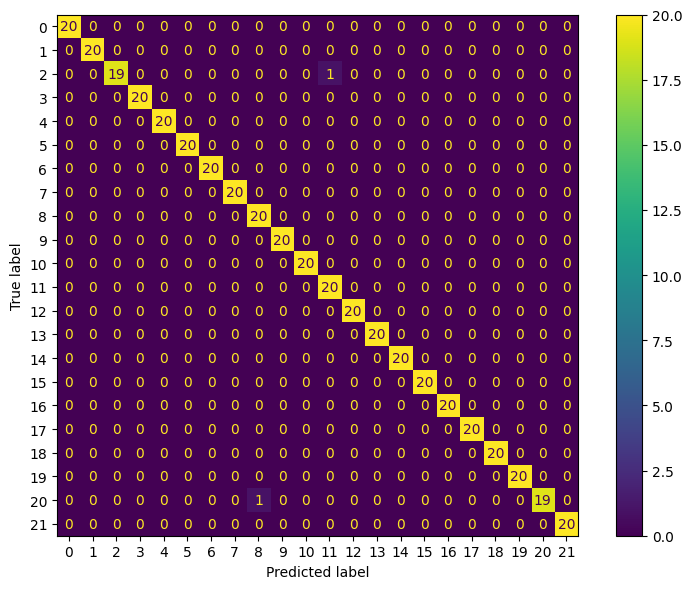

In [21]:
# 6) Load existing artifacts and baseline evaluation
from pathlib import Path
import joblib
scaler = joblib.load(MODELS_DIR/'crop_scaler.joblib')
labeler = joblib.load(MODELS_DIR/'crop_labelencoder.joblib')
baseline_model = joblib.load(MODELS_DIR/'crop_model.joblib')

# Encode targets (fit/transform already done in training; we only transform here)
y_train = labeler.transform(y_train_raw)
y_test = labeler.transform(y_test_raw)

# Align columns with scaler's expectation if present
if hasattr(scaler, 'feature_names_in_'):
    X_train = X_train[scaler.feature_names_in_]
    X_test = X_test[scaler.feature_names_in_]

X_train_t = scaler.transform(X_train)
X_test_t = scaler.transform(X_test)

y_pred_base = baseline_model.predict(X_test_t)
acc = accuracy_score(y_test, y_pred_base)
prec = precision_score(y_test, y_pred_base, average='macro', zero_division=0)
rec = recall_score(y_test, y_pred_base, average='macro', zero_division=0)
f1 = f1_score(y_test, y_pred_base, average='macro', zero_division=0)
print({'accuracy':acc, 'precision':prec, 'recall':rec, 'f1_macro':f1})

# Confusion matrix and report
fig, ax = plt.subplots(figsize=(8,6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_base, ax=ax)
fig.tight_layout()
conf_path = FIGURES_DIR / 'crop_baseline_confusion.png'
fig.savefig(conf_path)
print('Saved', conf_path)

report_txt = classification_report(y_test, y_pred_base, target_names=labeler.classes_)
(FIGURES_DIR/'crop_baseline_report.txt').write_text(report_txt)
print('Saved baseline report')

In [22]:
# 7) Metric helpers and plotting utilities
def evaluate_model(estimator, X_train, y_train, X_test, y_test):
    start = time.time()
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='macro', zero_division=0),
        'recall': recall_score(y_test, y_pred, average='macro', zero_division=0),
        'f1_macro': f1_score(y_test, y_pred, average='macro', zero_division=0),
        'elapsed_sec': time.time()-start,
    }
    return metrics, y_pred

def plot_confusion(y_true, y_pred, labels, title, out_path):
    fig, ax = plt.subplots(figsize=(8,6))
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=labels, ax=ax)
    ax.set_title(title)
    fig.tight_layout()
    fig.savefig(out_path)
    plt.close(fig)

def save_report(y_true, y_pred, labels, out_path):
    rep = classification_report(y_true, y_pred, target_names=labels)
    Path(out_path).write_text(rep)

In [23]:
# 8) Build model pipelines (RF, SVM, XGB, KNN)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
num_features = list(X_train.columns)
preprocess_pipe = ('scale', StandardScaler())

models = {}
models['rf'] = ('rf', RandomForestClassifier(random_state=RANDOM_STATE))
models['svm'] = ('svc', SVC(probability=True, random_state=RANDOM_STATE))
models['knn'] = ('knn', KNeighborsClassifier())
if xgb is not None:
    models['xgb'] = ('xgb', xgb.XGBClassifier(random_state=RANDOM_STATE, n_estimators=200, tree_method='hist', eval_metric='mlogloss'))

pipelines = {}
for key, (name, estimator) in models.items():
    if key in ['svm','knn']:
        pipelines[key] = Pipeline([('scaler', StandardScaler()), (name, estimator)])
    else:
        pipelines[key] = Pipeline([(name, estimator)])
list(pipelines.keys())

['rf', 'svm', 'knn', 'xgb']

In [24]:
# 9) Define hyperparameter search spaces (lists used for RandomizedSearchCV)
param_spaces = {
    'rf': {
        'rf__n_estimators': [100, 200, 300, 400],
        'rf__max_depth': [None, 10, 20, 30],
        'rf__min_samples_split': [2, 5, 10],
        'rf__min_samples_leaf': [1, 2, 4],
    },
    'svm': {
        'scaler__with_mean': [True],
        'scaler__with_std': [True],
        'svc__C': [0.1, 1, 3, 10],
        'svc__gamma': ['scale', 'auto'],
        'svc__kernel': ['rbf', 'poly'],
    },
    'knn': {
        'scaler__with_mean': [True],
        'scaler__with_std': [True],
        'knn__n_neighbors': [3,5,7,9,11],
        'knn__weights': ['uniform', 'distance'],
        'knn__p': [1,2],
    },
}
if 'xgb' in pipelines:
    param_spaces['xgb'] = {
        'xgb__n_estimators': [100, 200, 400],
        'xgb__max_depth': [3, 5, 8],
        'xgb__learning_rate': [0.05, 0.1, 0.2],
        'xgb__subsample': [0.7, 0.9, 1.0],
        'xgb__colsample_bytree': [0.7, 0.9, 1.0],
    }

In [25]:
# 10) Run hyperparameter tuning and capture CV results
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
scoring = 'f1_macro'
results = []
best_estimators = {}

for key, pipe in pipelines.items():
    space = param_spaces.get(key, {})
    if not space:
        # Fit without tuning
        print(f'[INFO] No search space for {key}, fitting directly...')
        metrics_, _ = evaluate_model(pipe, X_train, y_train, X_test, y_test)
        best_estimators[key] = pipe.fit(X_train, y_train)
        results.append({'model': key, 'cv_score': None, **metrics_})
        continue
    search = RandomizedSearchCV(pipe, space, n_iter=min(12, sum(len(v) for v in space.values())),
                                scoring=scoring, cv=cv, n_jobs=-1, random_state=RANDOM_STATE, verbose=1)
    search.fit(X_train, y_train)
    best_estimators[key] = search.best_estimator_
    print(f'[BEST] {key}:', search.best_params_, 'score:', search.best_score_)
    metrics_, _ = evaluate_model(search.best_estimator_, X_train, y_train, X_test, y_test)
    results.append({'model': key, 'cv_score': search.best_score_, **metrics_, 'best_params': search.best_params_})

results_df = pd.DataFrame(results).sort_values(by=['f1_macro','accuracy'], ascending=False)
display(results_df)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[BEST] rf: {'rf__n_estimators': 300, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 1, 'rf__max_depth': 20} score: 0.9925795497320032
[BEST] rf: {'rf__n_estimators': 300, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 1, 'rf__max_depth': 20} score: 0.9925795497320032
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[BEST] svm: {'svc__kernel': 'rbf', 'svc__gamma': 'scale', 'svc__C': 3, 'scaler__with_std': True, 'scaler__with_mean': True} score: 0.9828941114696318
[BEST] svm: {'svc__kernel': 'rbf', 'svc__gamma': 'scale', 'svc__C': 3, 'scaler__with_std': True, 'scaler__with_mean': True} score: 0.9828941114696318
Fitting 3 folds for each of 11 candidates, totalling 33 fits
Fitting 3 folds for each of 11 candidates, totalling 33 fits
[BEST] knn: {'scaler__with_std': True, 'scaler__with_mean': True, 'knn__weights': 'distance', 'knn__p': 1, 'knn__n_ne

,model,cv_score,accuracy,precision,recall,f1_macro,elapsed_sec,best_params
0,rf,0.992580,0.995455,0.995671,0.995455,0.995452,3.001989,"{'rf__n_estimators': 300, 'rf__min_samples_spl..."
3,xgb,0.992040,0.993182,0.993703,0.993182,0.993230,3.979068,"{'xgb__subsample': 0.7, 'xgb__n_estimators': 1..."
1,svm,0.982894,0.988636,0.989266,0.988636,0.988622,0.577108,"{'svc__kernel': 'rbf', 'svc__gamma': 'scale', ..."
2,knn,0.973189,0.981818,0.982348,0.981818,0.981690,0.033952,"{'scaler__with_std': True, 'scaler__with_mean'..."


In [26]:
# 11) Evaluate tuned models on test set and save artifacts
labels = list(range(len(labeler.classes_)))
for key, est in best_estimators.items():
    y_pred = est.predict(X_test)
    m = {
        'model': key,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='macro', zero_division=0),
        'recall': recall_score(y_test, y_pred, average='macro', zero_division=0),
        'f1_macro': f1_score(y_test, y_pred, average='macro', zero_division=0),
    }
    print('[TEST]', key, m)
    # Confusion
    out_png = FIGURES_DIR / f'confusion_{key}.png'
    plot_confusion(y_test, y_pred, labeler.classes_, f'Confusion: {key}', out_png)
    # Report
    out_txt = FIGURES_DIR / f'report_{key}.txt'
    save_report(y_test, y_pred, labeler.classes_, out_txt)

[TEST] rf {'model': 'rf', 'accuracy': 0.9954545454545455, 'precision': 0.9956709956709957, 'recall': 0.9954545454545454, 'f1_macro': 0.9954517027687758}
[TEST] svm {'model': 'svm', 'accuracy': 0.9886363636363636, 'precision': 0.9892660369933097, 'recall': 0.9886363636363636, 'f1_macro': 0.9886221288339389}
[TEST] svm {'model': 'svm', 'accuracy': 0.9886363636363636, 'precision': 0.9892660369933097, 'recall': 0.9886363636363636, 'f1_macro': 0.9886221288339389}
[TEST] knn {'model': 'knn', 'accuracy': 0.9818181818181818, 'precision': 0.9823479152426521, 'recall': 0.9818181818181817, 'f1_macro': 0.9816900365359928}
[TEST] knn {'model': 'knn', 'accuracy': 0.9818181818181818, 'precision': 0.9823479152426521, 'recall': 0.9818181818181817, 'f1_macro': 0.9816900365359928}
[TEST] xgb {'model': 'xgb', 'accuracy': 0.9931818181818182, 'precision': 0.9937032664305392, 'recall': 0.993181818181818, 'f1_macro': 0.9932303468888836}
[TEST] xgb {'model': 'xgb', 'accuracy': 0.9931818181818182, 'precision': 

In [27]:
# 12) Select and persist best model
best_key = results_df.iloc[0]['model'] if not results_df.empty else max(best_estimators.keys(), key=lambda k: 0)
best_model = best_estimators[best_key]
best_path = MODELS_DIR / 'crop_best_model.joblib'
joblib.dump(best_model, best_path)
print('Saved best model:', best_key, '->', best_path)
meta = {
    'best_model': best_key,
    'saved_at': datetime.datetime.now(datetime.timezone.utc).isoformat(),
    'cv_top': results_df.head(1).to_dict(orient='records') if not results_df.empty else [],
}
(MODELS_DIR/'crop_best_model_meta.json').write_text(json.dumps(meta, indent=2))
print('Saved best model metadata')

Saved best model: rf -> c:\Users\Snehal\Agroassist-ML\models\crop_best_model.joblib
Saved best model metadata


In [28]:
# 13) Feature importance and permutation importance
def plot_top_importances(imp, feat_names, title, out_path, top_k=10):
    s = pd.Series(imp, index=feat_names).sort_values(ascending=False).head(top_k)
    ax = s[::-1].plot(kind='barh', figsize=(7,5))
    ax.set_title(title)
    plt.tight_layout()
    plt.savefig(out_path)
    plt.close()

feat_names = list(X_train.columns)
if hasattr(best_model, 'feature_importances_'):
    out = FIGURES_DIR / f'importance_{best_key}.png'
    plot_top_importances(best_model.feature_importances_, feat_names, f'Feature Importance: {best_key}', out)
elif hasattr(best_model, 'coef_') and hasattr(best_model, 'classes_'):
    imp = np.mean(np.abs(best_model.coef_), axis=0) if best_model.coef_.ndim>1 else np.abs(best_model.coef_)
    out = FIGURES_DIR / f'importance_{best_key}.png'
    plot_top_importances(imp, feat_names, f'Coefficients: {best_key}', out)
else:
    print('Best model has no direct importance; running permutation importance...')
    pi = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=RANDOM_STATE)
    out = FIGURES_DIR / f'perm_importance_{best_key}.png'
    plot_top_importances(pi.importances_mean, feat_names, f'Permutation Importance: {best_key}', out)
    print('Saved permutation importance to', out)

Best model has no direct importance; running permutation importance...
Saved permutation importance to c:\Users\Snehal\Agroassist-ML\figures\perm_importance_rf.png
Saved permutation importance to c:\Users\Snehal\Agroassist-ML\figures\perm_importance_rf.png


In [29]:
# 14) Save consolidated metrics
stamp = int(time.time())
csv_path = FIGURES_DIR / f'crop_model_eval_metrics_{stamp}.csv'
results_df.to_csv(csv_path, index=False)
print('Saved metrics CSV:', csv_path)

Saved metrics CSV: c:\Users\Snehal\Agroassist-ML\figures\crop_model_eval_metrics_1759654682.csv


In [30]:
# 15) Write src/predict_utils.py quick reference
from src.predict_utils import predict_crop
print('predict_crop ready. Example usage:')
print("predict_crop({'N':90,'P':42,'K':43,'temperature':20.8,'humidity':82,'ph':6.5,'rainfall':203}) -> 'rice'")

predict_crop ready. Example usage:
predict_crop({'N':90,'P':42,'K':43,'temperature':20.8,'humidity':82,'ph':6.5,'rainfall':203}) -> 'rice'


In [31]:
# 16) Smoke test predict_utils with a sample input
sample = {'N':90,'P':42,'K':43,'temperature':21.0,'humidity':82.0,'ph':6.5,'rainfall':203.0}
try:
    pred = predict_crop(sample)
    print('Smoke test prediction:', pred)
except Exception as e:
    print('Smoke test failed:', e)

Smoke test prediction: kidneybeans


c:\Users\Snehal\Agroassist-ML\venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\Snehal\Agroassist-ML\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [32]:
# 17) Save aggregated results for Streamlit
agg_csv = FIGURES_DIR / 'crop_model_eval_metrics.csv'
results_df.to_csv(agg_csv, index=False)
print('Saved aggregated metrics CSV:', agg_csv)

Saved aggregated metrics CSV: c:\Users\Snehal\Agroassist-ML\figures\crop_model_eval_metrics.csv
